Librerias

In [20]:
# Importar las librerías necesarias
import pandas as pd
import sweetviz as sv
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt_tab')  # Nueva versión de punkt
nltk.download('stopwords', quiet=True)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Inspección inicial

In [21]:
# Cargar dataset
df = pd.read_csv('reddit_depression_dataset.csv')

print(f"Dimensiones: {df.shape}")
print(f"\nColumnas: {list(df.columns)}")
print(f"\nTipos de datos:")
print(df.dtypes)

C:\Users\nicol\AppData\Local\Temp\ipykernel_32128\2930088934.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('reddit_depression_dataset.csv')


Dimensiones: (2470778, 8)

Columnas: ['Unnamed: 0', 'subreddit', 'title', 'body', 'upvotes', 'created_utc', 'num_comments', 'label']

Tipos de datos:
Unnamed: 0       object
subreddit        object
title            object
body             object
upvotes         float64
created_utc     float64
num_comments    float64
label           float64
dtype: object


In [22]:
#Hacer un sample de 100000 balanceado
df_depressed = df[df['label'] == 1].sample(n=50000, random_state=42)
df_not_depressed = df[df['label'] == 0].sample(n=50000, random_state=42)
df = pd.concat([df_depressed, df_not_depressed])

In [23]:
df.head()

,Unnamed: 0,subreddit,title,body,upvotes,created_utc,num_comments,label
2309899,9757951,depression,Lucked out unbelievably into finding an excell...,I spoke with a counsellor I've never had befor...,5.0,1.523614e+09,2.0,1.0
2027061,8422580,SuicideWatch,I Love You All.,I mean it. Love to every one of you.\n\nI'm si...,6.0,1.435033e+09,8.0,1.0
2153593,9072862,SuicideWatch,I don’t think I’ll be here at the end of the m...,"I have everything ready, note and plan. When t...",4.0,1.644931e+09,NaN,1.0
2434563,10496704,depression,"Everyone thinks I've moved on, when in reality...","I haven't gotten better, instead I've just acc...",39.0,1.627223e+09,5.0,1.0
2304694,9732151,depression,I hate depression. I just got a wave of negati...,[negative thoughts]\n\nNow stay. Stay right th...,11.0,1.519341e+09,1.0,1.0


In [24]:
df.isnull().sum()

Unnamed: 0          0
subreddit           0
title               0
body            13124
upvotes             0
created_utc         0
num_comments     5847
label               0
dtype: int64

In [25]:
#Ver duplicados
df.duplicated().sum()

np.int64(0)

In [ ]:
# Normalización avanzada (opcional)
def normalize_text_advanced(text):
    """
    Función para normalización avanzada con stopwords y stemming
    """
    if pd.isna(text) or text == '':
        return ''
    
    try:
        # Convertir a string y minúsculas
        text = str(text).lower()
        
        # Remover caracteres especiales y números
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenizar
        tokens = word_tokenize(text)
        
        # Remover stopwords en inglés
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
        
        # Aplicar stemming
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]
        
        # Unir tokens
        text = ' '.join(tokens)
        
        return text
    except Exception as e:
        # Si hay error, retornar texto básico limpio
        text = str(text).lower()
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text

In [28]:
# Remover columnas problemáticas 
df_clean = df.copy()

df_clean.rename(columns={'Unnamed: 0': 'id'}, inplace=True)
# Eliminar la columna 'id', no es relevante
df_clean = df_clean.drop(['id', 'subreddit'], axis=1)
#num_comments reemplazar na por 0 y castear a int
df_clean['num_comments'] = df_clean['num_comments'].fillna(0).astype(int)
df_clean['upvotes'] = df_clean['upvotes'].dropna().astype(int)
df_clean.dropna(inplace=True)

#Combinar title y body en una sola columna body
df_clean['body'] = df_clean['title'] + ' ' + df_clean['body']
df_clean = df_clean.drop(['title'], axis=1)

df_clean['body'] = df_clean['body'].apply(normalize_text_advanced)

# Crear nueva variable 'n_words_body' con el número de palabras en la columna 'body'
df_clean['n_words_body'] = df_clean['body'].apply(lambda x: len(str(x).split()))

#Crear columna con conteo de numero de veces que se repite la palabra mas frecuente en body
df_clean['most_freq_word_count'] = df_clean['body'].apply(lambda x: pd.Series(x.split()).value_counts().max() if x else 0)

#Crear nueva variable con numero de palabras distintas en body
df_clean['n_unique_words_body'] = df_clean['body'].apply(lambda x: len(set(str(x).split())))


#Longitud promedio de palabras
df_clean['avg_word_length'] = df_clean['body'].apply(
    lambda x: sum(len(word) for word in str(x).split()) / len(str(x).split()) if str(x).split() else 0
)

# Lista de palabras emocionales comunes en ingles
emotion_words = {
    'sad', 'depress', 'anxi', 'stress', 'worri', 'fear', 'anger', 'frustrat', 
    'hopeless', 'worthless', 'guilt', 'shame', 'lone', 'tire', 'exhaust',
    'pain', 'hurt', 'suffer', 'struggl', 'overwhelm', 'despair', 'empti'
}

def count_emotion_words(text):
    if pd.isna(text) or text == '':
        return 0
    words = str(text).split()
    return sum(1 for word in words if any(emotion in word for emotion in emotion_words))

df_clean['emotion_word_count'] = df_clean['body'].apply(count_emotion_words)

#Ratio de repetición de palabras
df_clean['repetition_ratio'] = df_clean['most_freq_word_count'] / df_clean['n_words_body']
df_clean['repetition_ratio'] = df_clean['repetition_ratio'].fillna(0) 

# Filtrar outliers en 'most_freq_word_count'
df_clean = df_clean[df_clean['n_words_body'] < 200]
df_clean = df_clean[df_clean["most_freq_word_count"] < 200]
df_clean = df_clean[df_clean["n_unique_words_body"] > 4]

In [29]:
df_clean.shape

(78206, 11)

In [30]:
df_clean.value_counts("label")

label
1.0    42582
0.0    35624
Name: count, dtype: int64

In [31]:

df_clean.to_csv('reddit_depression_dataset_clean.csv', index=False)

In [32]:
df_analysis = df_clean.copy()

In [ ]:
# Crear el reporte de análisis con la variable objetivo 
#sv_report = sv.analyze(df_analysis, target_feat='label')

#sv_report.show_html('sweetviz_reddit_depression_report.html')

# Visualizaciones

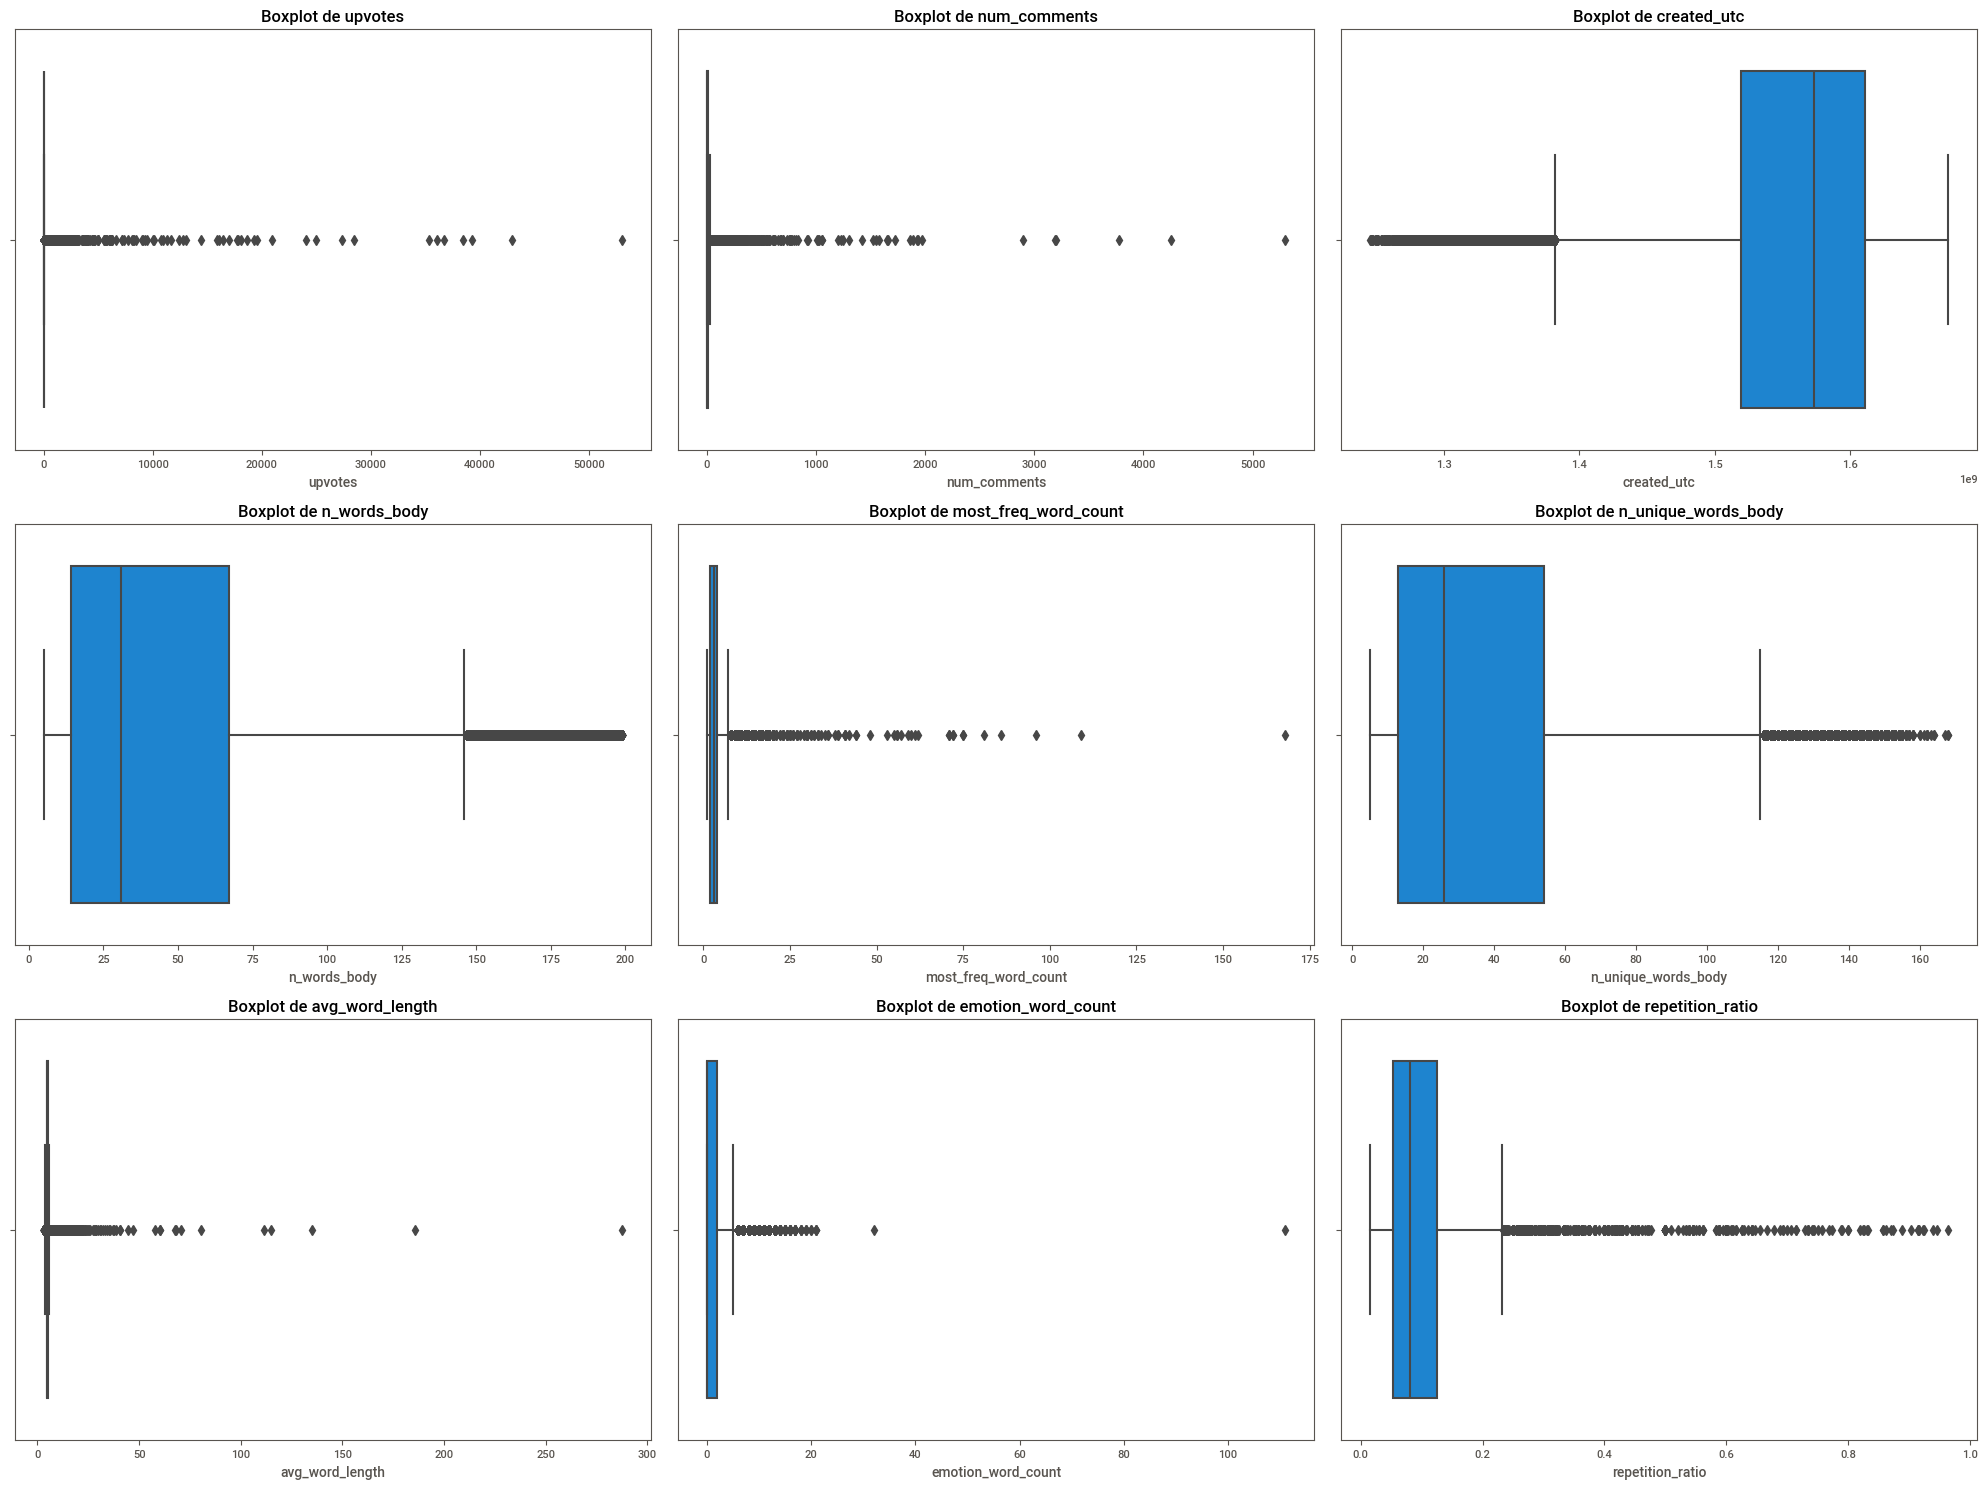

In [33]:
# Boxplots individuales de variables numéricas (incluyendo nuevas variables)
numeric_cols = ['upvotes', 'num_comments', 'created_utc', 'n_words_body', 'most_freq_word_count', 
                'n_unique_words_body', 'avg_word_length', 'emotion_word_count', 'repetition_ratio']

plt.figure(figsize=(20, 15))  # Aumentar tamaño para acomodar más gráficos
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 3, i)  # Cambiar a 3 filas, 3 columnas para las 9 variables
    sns.boxplot(x=df_analysis[col])
    plt.title(f'Boxplot de {col}')
plt.tight_layout()
plt.show()

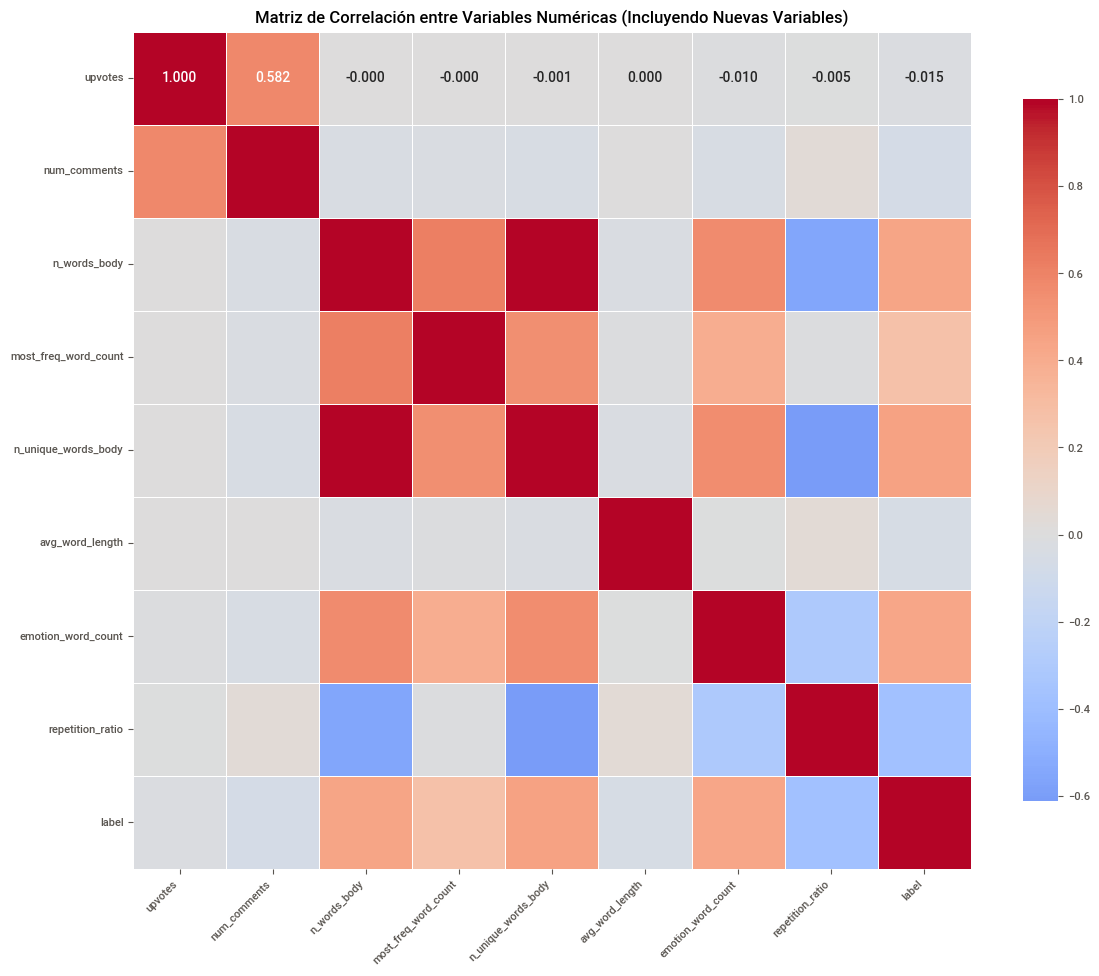

In [34]:
# Matriz de Correlación (incluyendo nuevas variables)
plt.figure(figsize=(12, 10))  # Aumentar tamaño para acomodar más variables
correlation_matrix = df_analysis[['upvotes', 'num_comments', 'n_words_body', 'most_freq_word_count', 
                                 'n_unique_words_body', 'avg_word_length', 'emotion_word_count', 
                                 'repetition_ratio', 'label']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": .8}, fmt='.3f')
plt.title('Matriz de Correlación entre Variables Numéricas (Incluyendo Nuevas Variables)')
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para mejor legibilidad
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

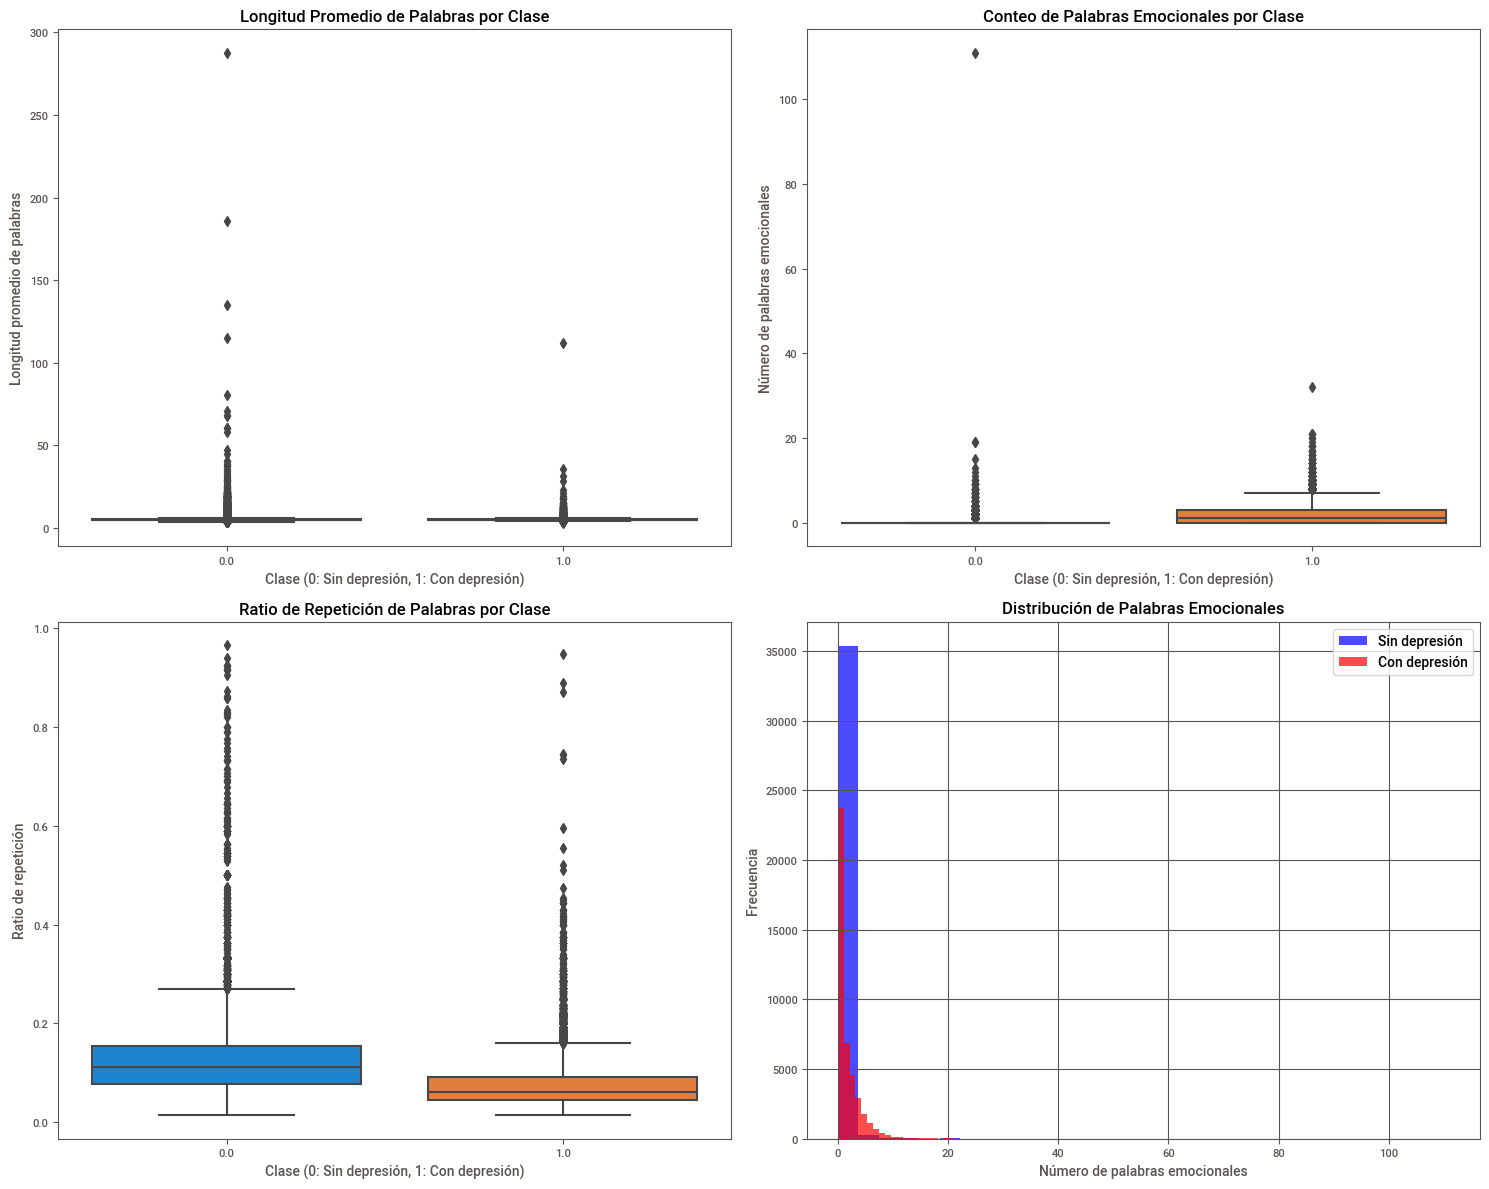

=== ESTADÍSTICAS DE NUEVAS VARIABLES POR CLASE ===

1. LONGITUD PROMEDIO DE PALABRAS:
         count      mean       std    min       25%       50%       75%  \
label                                                                     
0.0    35624.0  5.010516  2.564355  3.125  4.500000  4.793291  5.133333   
1.0    42582.0  4.833469  0.744229  3.100  4.608696  4.791667  5.000000   

              max  
label              
0.0    287.684211  
1.0    111.666667  

2. CONTEO DE PALABRAS EMOCIONALES:
         count      mean       std  min  25%  50%  75%    max
label                                                        
0.0    35624.0  0.229115  0.920498  0.0  0.0  0.0  0.0  111.0
1.0    42582.0  1.847659  2.130050  0.0  0.0  1.0  3.0   32.0

3. RATIO DE REPETICIÓN:
         count      mean       std       min       25%       50%       75%  \
label                                                                        
0.0    35624.0  0.122987  0.069241  0.014925  0.076923  0.111111  0.

In [35]:
# Análisis específico de las nuevas variables por clase de depresión
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Distribución de avg_word_length por clase
sns.boxplot(data=df_analysis, x='label', y='avg_word_length', ax=axes[0,0])
axes[0,0].set_title('Longitud Promedio de Palabras por Clase')
axes[0,0].set_xlabel('Clase (0: Sin depresión, 1: Con depresión)')
axes[0,0].set_ylabel('Longitud promedio de palabras')

# 2. Distribución de emotion_word_count por clase  
sns.boxplot(data=df_analysis, x='label', y='emotion_word_count', ax=axes[0,1])
axes[0,1].set_title('Conteo de Palabras Emocionales por Clase')
axes[0,1].set_xlabel('Clase (0: Sin depresión, 1: Con depresión)')
axes[0,1].set_ylabel('Número de palabras emocionales')

# 3. Distribución de repetition_ratio por clase
sns.boxplot(data=df_analysis, x='label', y='repetition_ratio', ax=axes[1,0])
axes[1,0].set_title('Ratio de Repetición de Palabras por Clase')
axes[1,0].set_xlabel('Clase (0: Sin depresión, 1: Con depresión)')
axes[1,0].set_ylabel('Ratio de repetición')

# 4. Histograma comparativo de emotion_word_count
df_analysis[df_analysis['label']==0]['emotion_word_count'].hist(alpha=0.7, label='Sin depresión', 
                                                               bins=30, ax=axes[1,1], color='blue')
df_analysis[df_analysis['label']==1]['emotion_word_count'].hist(alpha=0.7, label='Con depresión', 
                                                               bins=30, ax=axes[1,1], color='red')
axes[1,1].set_title('Distribución de Palabras Emocionales')
axes[1,1].set_xlabel('Número de palabras emocionales')
axes[1,1].set_ylabel('Frecuencia')
axes[1,1].legend()

plt.tight_layout()
plt.show()

# Estadísticas descriptivas por clase para las nuevas variables
print("=== ESTADÍSTICAS DE NUEVAS VARIABLES POR CLASE ===")
print("\n1. LONGITUD PROMEDIO DE PALABRAS:")
print(df_analysis.groupby('label')['avg_word_length'].describe())
print("\n2. CONTEO DE PALABRAS EMOCIONALES:")
print(df_analysis.groupby('label')['emotion_word_count'].describe())
print("\n3. RATIO DE REPETICIÓN:")
print(df_analysis.groupby('label')['repetition_ratio'].describe())

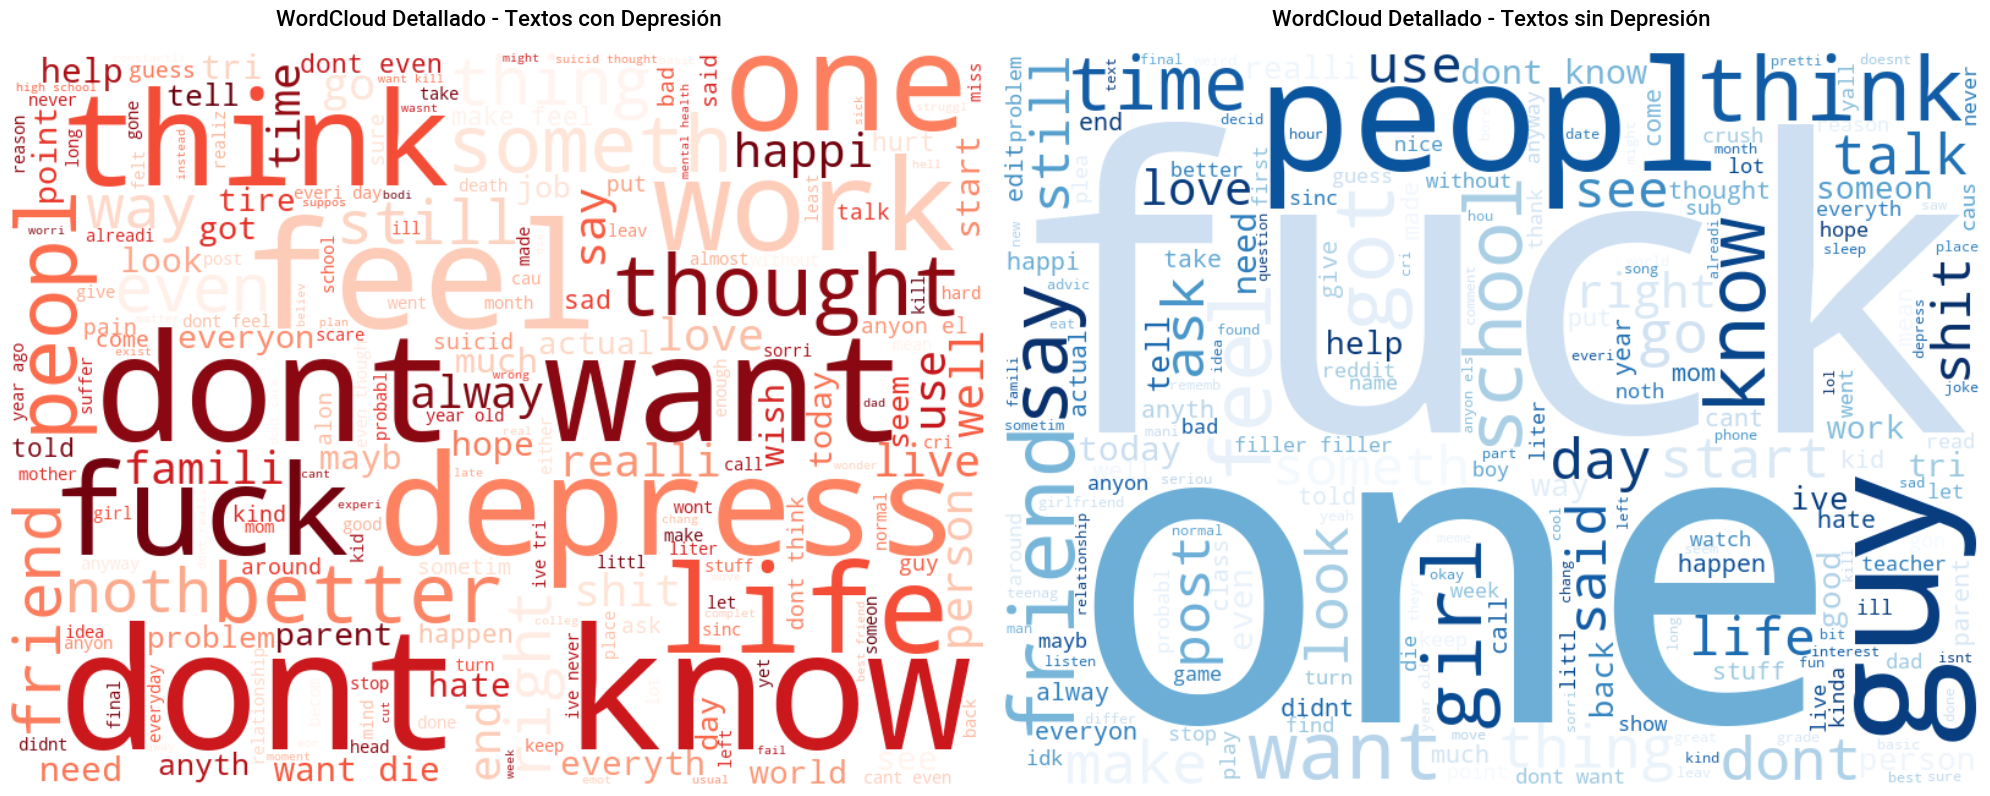

In [36]:
# WordCloud individual más grande para cada clase
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# WordCloud para depresión - más detallado
depressed_text = ' '.join(df_analysis[df_analysis['label'] == 1]['body'].dropna())
wordcloud_dep_large = WordCloud(width=800, height=600,
                                background_color='white',
                                max_words=200,
                                relative_scaling=0.5,
                                colormap='Reds',
                                prefer_horizontal=0.7).generate(depressed_text)
axes[0].imshow(wordcloud_dep_large, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('WordCloud Detallado - Textos con Depresión', fontsize=16, pad=20)

# WordCloud para no depresión - más detallado
non_depressed_text = ' '.join(df_analysis[df_analysis['label'] == 0]['body'].dropna())
wordcloud_non_dep_large = WordCloud(width=800, height=600,
                                    background_color='white',
                                    max_words=200,
                                    relative_scaling=0.5,
                                    colormap='Blues',
                                    prefer_horizontal=0.7).generate(non_depressed_text)
axes[1].imshow(wordcloud_non_dep_large, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('WordCloud Detallado - Textos sin Depresión', fontsize=16, pad=20)

plt.tight_layout()
plt.show()

# Análisis por cortes

 Variables de corte seleccionadas:
1. **Número de palabras**: Comparar posts con muchas vs pocas palabras
2. **Número de comentarios**: Comparar posts con poca vs mucha interacción

In [37]:
# Analizar la distribución de numero de palabras
print("Estadísticas de número de palabras en body:")
print(df_analysis['n_words_body'].describe())
# Definir el punto de corte usando la mediana
words_median = df_analysis['n_words_body'].median()
print(f"\nMediana de número de palabras: {words_median}")
# Crear los grupos
df_pocas_palabras = df_analysis[df_analysis['n_words_body'] <= words_median]
df_muchas_palabras = df_analysis[df_analysis['n_words_body'] > words_median]
print(f"Posts con pocas palabras (≤{words_median}): {len(df_pocas_palabras)}")
print(f"Posts con muchas palabras (>{words_median}): {len(df_muchas_palabras)}")
# Generar reporte de comparación
#sv_report_words = sv.compare([df_pocas_palabras, f"Pocas Palabras (≤{words_median})"], 
#                             [df_muchas_palabras, f"Muchas Palabras (>{words_median})"], 
#                             target_feat='label')
#sv_report_words.show_html("sweetviz_comparacion_palabras.html")

Estadísticas de número de palabras en body:
count    78206.000000
mean        47.558435
std         43.968775
min          5.000000
25%         14.000000
50%         31.000000
75%         67.000000
max        199.000000
Name: n_words_body, dtype: float64

Mediana de número de palabras: 31.0
Posts con pocas palabras (≤31.0): 39300
Posts con muchas palabras (>31.0): 38906


In [38]:
# Analizar la distribución de comentarios (eliminando valores nulos)
df_with_comments = df_analysis.dropna(subset=['num_comments'])

print("Estadísticas de número de comentarios:")
print(df_with_comments['num_comments'].describe())

# Definir el punto de corte usando la mediana
comments_median = df_with_comments['num_comments'].median()
print(f"\nMediana de comentarios: {comments_median}")

# Crear los grupos
df_pocos_comentarios = df_with_comments[df_with_comments['num_comments'] <= comments_median]
df_muchos_comentarios = df_with_comments[df_with_comments['num_comments'] > comments_median]

print(f"Posts con pocos comentarios (≤{comments_median}): {len(df_pocos_comentarios)}")
print(f"Posts con muchos comentarios (>{comments_median}): {len(df_muchos_comentarios)}")

# Generar reporte de comparación
#sv_report_comments = sv.compare([df_pocos_comentarios, f"Pocos Comentarios (≤{comments_median})"], 
#                                [df_muchos_comentarios, f"Muchos Comentarios (>{comments_median})"], 
#                                target_feat='label')

#sv_report_comments.show_html("sweetviz_comparacion_comentarios.html")

Estadísticas de número de comentarios:
count    78206.000000
mean        11.693770
std         48.571785
min          0.000000
25%          2.000000
50%          6.000000
75%         12.000000
max       5300.000000
Name: num_comments, dtype: float64

Mediana de comentarios: 6.0
Posts con pocos comentarios (≤6.0): 43629
Posts con muchos comentarios (>6.0): 34577
